In [ ]:
%env JOBLIB_TEMP_FOLDER=/tmp

In [ ]:
!conda install -c conda-forge gdcm -y

Table of Contents
* [Coordinate System For Medical Imaging](#coordinate-system)
* [About data](#about-data)
* [What is DICOM?](#dicom)
* [Conversion to Hounsfield Units](#hounsfield)
* [Windowing](#windowing)
* [Histogram Analysis](#histogram-analysis)
* [Storing metadata in dataframe](#metadata)
* [Voxel Size and Volume](#voxel-size)
* [Resampling](#resample)
* [3D Plotting](#3d-plot)
* [Segmentation](#segmentation)

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import scipy.ndimage
from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from sklearn.cluster import KMeans
import shutil
import cv2
import pydicom
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
import seaborn as sns
from IPython.display import HTML
import gdcm

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
'''
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
'''
# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
def set_options():
    pd.set_option('display.max_columns', 100)
    pd.set_option('display.max_colwidth', None)
    pd.set_option('display.max_rows', 1000)

In [ ]:
set_options()

<a id="coordinate-system"></a>
# Coordinate Systems in medical imaging

Coordinate system is used for identifying the location of a point. Three types coordinate systems commonly used in imaging applications: the world, anatomical and the medical image coordinate system.

We will talk about Anatomical coordinate system. This system has three planes and **dataset we will be using is on Axial Plane.**

* Axial plane -  The axial plane is actually when you place point of view above the patient and look down. Depending on the region of the 3D medical image you will observe different anatomical structures. For a 3D total body scan, if you had a control-bar over this 2D view you would start from a 2D slice of the head, and by increasing you would end up in the legs. Let’s practically call this view the “drone plane” or “top-view”. Slices near to head is known as superior and towards feet is known as inferior. Below is axial plane of lungs CT Scans.

* Sagittal plane - Basically, this is a side view. Instead of looking from above the patient, now we look from the side. The side can be either right or left. Which side and direction is the positive one, depends on the coordinate system.

* Coronal plane – In this point of view is either in front of eyes(anterior plane) or back of the patient(posterior plane)

<a id="about-data"></a>
# About data
Medical dataset containing lungs CT scans of patients diagnosed with pulmonary fibrosis a disorder with no known cause and no known cure, created by scarring of the lungs. Prognosis of the troubling disease becomes frightening for the patients because outcomes can range from long-term stability to rapid deterioration, but doctors aren’t easily able to tell where an individual may fall on that spectrum. This is where data science can help in predicting the detoriating condition of the patients. Detailed description about data is found [here.](https://www.kaggle.com/c/osic-pulmonary-fibrosis-progression/data)

In [ ]:
TRAIN_PATH = '../input/osic-pulmonary-fibrosis-progression/train.csv'
TRAIN_IMG_PATH = '../input/osic-pulmonary-fibrosis-progression/train'
TEST_PATH = '../input/osic-pulmonary-fibrosis-progression/test.csv'
TEST_IMG_PATH = '../input/osic-pulmonary-fibrosis-progression/test'
SUBMISSION_PATH = '../input/osic-pulmonary-fibrosis-progression/sample_submission.csv'

In [ ]:
'''Load data'''
train = pd.read_csv(TRAIN_PATH)
test = pd.read_csv(TEST_PATH)

In [ ]:
# Duplicates on basis of patient and weeks
train[train.duplicated(['Patient','Weeks'], keep=False)]

In [ ]:
# Remove duplicates
train = train.drop_duplicates()

In [ ]:
train.head()

<a id="dicom"></a>
# What is DICOM?

A DICOM image file is an outcome of the Digital Imaging and Communications in Medicine standard and represented as .dcm. Because of its ease of integration and continuous evolution this communication standard has over the years achieved a nearly universal level of acceptance among vendors of radiological equipment.DICOM differs from other image formats because it groups information into datasets. DICOM file consist of header and image data collectively in one file. We will see later how these group of information looks like and interpreted.
Detailed information about DICOM can be read [here.](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3354356/)

Video for better understanding about DICOM images.

In [ ]:
HTML('<iframe width="600" height="400" src="https://www.youtube.com/embed/KZld-5W99cI" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>')

In [ ]:
## In this dataset ImagePosition is not available so we will sort the slices on InstanceNumber.
def load_slices(path):
    filenames = os.listdir(path)
    slices = [pydicom.dcmread(f'{path}/{file}') for file in filenames]
    slices.sort(key = lambda x: int(x.InstanceNumber), reverse=True)
    return slices

In [ ]:
scans = load_slices(f'{TRAIN_IMG_PATH}/ID00007637202177411956430')
scans[0]

<a id="hounsfield"></a>
# Conversion to Hounsfield Units
The Hounsfield scale is a quantitative scale for describing radiodensity in medical CT scan and provides an accurate density for the type of tissue. Plain x-rays which only displays 5 densities (i.e. air/fat/soft tissue/bone/metal), CT displays a huge range of densities ranging from air (black) to bone (white). On the Hounsfield scale, water represented by 0 value, air is represented by a value of −1000 (black on the grey scale) and bone between +700 (cancellous bone) to +3000 (dense bone) (white on the grey scale). As bones are much denser than surrounding soft tissues, they show up very clearly in CT images. Raw pixel values of images gets convereted into Hounsfield Units because the spectral composition of the x-rays depends on the measurement settings like acquisition parameters and tube voltage. By normalizing to values of water and air (water has HU 0 and air -1000) the images of different measurements are becoming comparable.
Read more about Hounsfield units on [Hounsfield Scale](https://www.sciencedirect.com/topics/medicine-and-dentistry/hounsfield-scale)

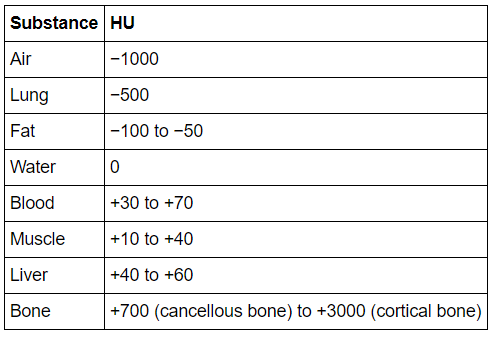

Below methods we consider eveything below -1000 as air. 

In [ ]:
# Rescale intercept, (0028|1052), and rescale slope (0028|1053) are DICOM tags that specify the linear 
# transformation from pixels in their stored on disk representation to their in memory representation.
# Whenever the values stored in each voxel have to be scaled to different units, 
# Dicom makes use of a scale factor using two fields into the header 
# defining the slope and the intercept of the linear transformation to be used to 
# convert pixel values to real world values.

def get_pixels_hu(slices):
    image = np.stack([s.pixel_array for s in slices])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0
    image[image <= -1000] = 0
    
    # Convert to Hounsfield units (HU)
    for slice_number in range(len(slices)):
        
        intercept = slices[slice_number].RescaleIntercept
        slope = slices[slice_number].RescaleSlope
        
        if slope != 1:
            image[slice_number] = slope * image[slice_number].astype(np.float64)
            image[slice_number] = image[slice_number].astype(np.int16)
            
        image[slice_number] += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

<a id="windowing"></a>
# Windowing
Windowing is the process in which the grayscale of a particular image can be adjusted. Windowing uses two values window width and window level for getting a right/interested window. The window width is the range of the grayscale that can be displayed. The center of grayscale range is referred to as the window level.Window width controls contrast and window level controls brightness. That is why windowing also known as grey-level mapping, contrast stretching, histogram modification or contrast enhancement. A large window width means there is a long grayscale and the transition black to white will take longer and vice versa for smaller window width. An example to better explain:
WW of 100 HU could mean the grayscale only ranges from 0HU to +100 HU, with a WL of +50 HU.
For Lungs window width is 1500 and window level is -600, so grayscale ranges from 150HU to -1350HU.
More about windowing can be read [here.](https://radiopaedia.org/articles/windowing-ct?lang=us)
How to get window width and level is explained briefly in [this](https://www.researchgate.net/publication/272179277_Determining_effective_window_width_and_center_using_different_windowing_techniques_for_radio_therapy_images) article.

In [ ]:
def apply_window(hu_image, center, width):
    hu_image = hu_image.copy()
    min_value = center - width // 2
    max_value = center + width // 2
    hu_image[hu_image < min_value] = min_value
    hu_image[hu_image > max_value] = max_value
    return hu_image

<a id="histogram-analysis"></a>
# Histogram Analysis
Lets plot histogram for image pixels after converting to HU and raw pixel values. After converting to HU we can see there is lot of air(-1000) in the scan. Some fat and muscle is also seen.

In [ ]:
train.loc[0]['Patient']

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(20,5))
example = train.loc[0]['Patient']
scans = load_slices(f'{TRAIN_IMG_PATH}/{example}')
rescaled_images=get_pixels_hu(scans)
images = [scan.pixel_array for scan in scans]
for i in range(10):
    sns.distplot(images[i].flatten(), ax=ax[0])
    sns.distplot(rescaled_images[i].flatten(), ax=ax[1])
ax[0].set_title("Raw pixel array distributions for 10 examples")
ax[1].set_title("HU unit distributions for 10 examples")

<a id="metadata"></a>
# Storing metadata in dataframe
Every DICOM image has lot of metadata as we saw earlier for one scan. Lets put this metadata in dataframe for easy access. 

In [ ]:
def get_dicom_raw(dicom):
    return ({attr:getattr(dicom, attr) for attr in dir(dicom) if attr[0].isupper() and attr not in ['PixelData']})

In [ ]:
%%time
# Get dicom metadata
# Image features like lung volume are implementation from a detailed discussion "Domain expert's insight" by Dr. Konya.
# https://www.kaggle.com/c/osic-pulmonary-fibrosis-progression/discussion/165727

def get_dicom_metadata(df):
    patients = df.Patient.unique()
    dicom_metadata = []
    for patient in patients:
        path = f'{TRAIN_IMG_PATH}/{patient}'
        img_list = os.listdir(path)
        for img in img_list:
            image = pydicom.dcmread(f'{path}/{img}')
            record = get_dicom_raw(image)
            raw = image.pixel_array
            pixelspacing_r, pixelspacing_c = image.PixelSpacing[0], image.PixelSpacing[1]
            row_distance = pixelspacing_r * image.Rows
            col_distance = pixelspacing_c * image.Columns
            record.update({'raw_min':raw.min(),
                        'raw_max':raw.max(),
                        'raw_mean':raw.mean(),
                        'raw_std':raw.std(),
                        'raw_diff':raw.max()-raw.min(),
                        'pixel_spacing_area':pixelspacing_r * pixelspacing_c,
                        'img_area':image.Rows * image.Columns,
                        'pixel_row_distance':row_distance,
                        'pixel_col_distance':col_distance,
                        'slice_area_cm2':(0.1 * row_distance) * (0.1 * col_distance),
                        'slice_vol_cm3':(0.1 * image.SliceThickness) * (0.1 * row_distance) * (0.1 * col_distance),
                        'patient_img_path':f'{path}/{img}'})

            dicom_metadata.append(record)
            
    metadata_df = pd.DataFrame(dicom_metadata)
    metadata_df.to_pickle('metadata_df.pkl')
    return metadata_df

In [ ]:
%%time
metadata_df = get_dicom_metadata(train.copy())
metadata_df.head()

<a id="voxel-size"></a>
# Voxel Size and Volume
Volume of scans vary highly. Does it mean that lungs of images having more voxel volume are bigger than others? NO certainly not. Let's understand what is voxel? Voxel is 3D pixel having pixel spacing shows distance travelled by a pixel in x and y coordinates and slice thickness as z coordinate. Voxel we can imagine like a cuboid. So if pixel spacing(size) is more than definitely volume of image will be more. Lets plot variance of area, volume and pixel spacing to have an idea about number of images having large volumes. 

In [ ]:
plt.tight_layout()
fig, ax = plt.subplots(2, 2, figsize=(20,10))
sns.distplot(metadata_df.pixel_row_distance, ax=ax[0,0], color='green')
sns.distplot(metadata_df.pixel_col_distance, ax=ax[0,1], color='blue')
sns.distplot(metadata_df.slice_area_cm2, ax=ax[1,0], color='pink')
sns.distplot(metadata_df.slice_vol_cm3, ax=ax[1,1], color='magenta')
ax[0,0].set_title("Pixel Rows Distance")
ax[0,0].set_xlabel("Pixel Rows")
ax[0,1].set_title("Pixel Column Distance")
ax[0,1].set_xlabel("Pixel Columns")
ax[1,0].set_title("CT-slice area in $cm^{2}$")
ax[1,0].set_xlabel("Area in $cm^{2}$")
ax[1,1].set_title("CT-slice volume in $cm^{3}$")
ax[1,1].set_xlabel("Volume in $cm^{3}$")

In [ ]:
# It is clearly visible that area and volume of lungs vary a lot. Let's show images with maximum volume and minimum volume.
highest_vol_patients = list(metadata_df[metadata_df.slice_vol_cm3 == max(metadata_df.slice_vol_cm3)]['PatientID'])
lowest_vol_patients = list(metadata_df[metadata_df.slice_vol_cm3 == min(metadata_df.slice_vol_cm3)]['PatientID'])
# Load scans for highest and lowest volume lung patients
max_vol_scans = load_slices(f"{TRAIN_IMG_PATH}/{highest_vol_patients[0]}")
min_vol_scans = load_slices(f"{TRAIN_IMG_PATH}/{lowest_vol_patients[0]}")
# Convert to HU
max_vol_hu_imgs = get_pixels_hu(max_vol_scans)
min_vol_hu_imgs = get_pixels_hu(min_vol_scans)
# Apply windowing]
# We can try with different window width and levels.
max_vol_window_img = apply_window(max_vol_hu_imgs[20], -600, 1200)
min_vol_window_img = apply_window(min_vol_hu_imgs[18], -600, 1200)
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(max_vol_window_img, cmap="YlGnBu")
ax[0].set_title("CT with large volume")
ax[1].imshow(min_vol_window_img, cmap="YlGnBu")
ax[1].set_title("CT with small volume")

<a id="resample"></a>
# Resampling
Voxel size resampling is an appropriate preprocessing step for image data sets acquired with variable voxel sizes in order to obtain more reproducible CT features. We found that some of radiomics features were voxel size and gray level discretization dependent. The introduction of normalizing factors in their definitions greatly reduced or removed these dependencies. In computed tomography, voxel size in a region of interest depends on both pixel dimensions (x-y plane) and slice thickness (z-axis), assuming slice thickness equals interslice distance. Any change in these two parameters changes CT image resolution or voxel size. A minimally curation step may be to resample image sets so that all have the same voxel size. In this paper, voxel size resampling was investigated as a way to minimize the variability in feature values due to differing voxel sizes.

Voxel intensities within a region of interest (ROI) are typically resampled into a limited number of discrete values or bin sizes before calculating feature values. Different studies have used different gray level resampling before extracting texture features. Later normalization is also done to improve robustness of these features.


In [ ]:
metadata_df.SliceThickness.unique()

In [ ]:
# Lets see thickness for slices before thinking about resampling.
patient1 = train.Patient.unique()[0]
patient2 = train.Patient.unique()[5]
scans1 = load_slices(f"{TRAIN_IMG_PATH}/{patient1}")
scans2 = load_slices(f"{TRAIN_IMG_PATH}/{patient2}")
print(f"{scans1[0].SliceThickness}, {scans1[0].PixelSpacing}")
print(f"{scans2[0].SliceThickness}, {scans2[0].PixelSpacing}")


In [ ]:
patient1_hu_scans = get_pixels_hu(scans1)
patient2_hu_scans = get_pixels_hu(scans2)

In [ ]:
def resample(image, scan, new_spacing=[1,1,1]):
    # Determine current pixel spacing
    spacing = np.array([scan[0].SliceThickness] + list(scan[0].PixelSpacing), dtype=np.float32)
    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor)
    return image, new_spacing

In [ ]:
image1, rounded_new_spacing1 = resample(patient1_hu_scans, scans1, [1,1,1])
image2, rounded_new_spacing2 = resample(patient2_hu_scans, scans2, [1,1,1])
print(f"Original shape : {patient2_hu_scans.shape}")
print(f"Shape after resampling : {image2.shape}")

<a id="3d-plot"></a>
# 3D Plotting

In [ ]:
def plot_3d(image,threshold=800):
    
    # Position the scan upright, 
    # so the head of the patient would be at the top facing the   
    # camera
    p = image.transpose(2,1,0)
    
    verts, faces, _, _ = measure.marching_cubes_lewiner(p, threshold)
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    # Fancy indexing: `verts[faces]` to generate a collection of    
    # triangles
    mesh = Poly3DCollection(verts[faces], alpha=0.70)
    face_color = [0.45, 0.45, 0.75]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)
    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])
    plt.show()

In [ ]:
plot_3d(image1)

In [ ]:
plot_3d(patient1_hu_scans)

<a id="segmentation"></a>
# Segmentation

Segmentation is most important part of medical image processing as it extracts region of interest. Segmentation defines narrowly what algorithm want to look at, so definitely CNN will perform better on segmented images rather than on whole chest image.
Segmentation is done by many ways and clustering is most common among all. Clustering has several techniques such as K-means clustering, hierarchical clustering, divisive clustering, and mean shift clustering. Moreover, due to the irregular and fuzzy borders in most of the medical images, fuzzy set and neutrosophic set theories become important in the segmentation process to handle uncertainty in the medical images. Read more about medical image segmentation [here.](https://www.sciencedirect.com/topics/engineering/medical-image-segmentation)
After clustering images are morphed using erosion(contraction) and dialation(expansion) to remove unwanted border areas and label different reasons separately. So the steps goes as:
1. Normalization of image.
2. Clustering for separating lung with everything else.
3. Threshold image.
4. Morphology - Erosion followed by dialation.
5. Label different regions and define regions with different colors.
6. Create lung mask.
7. Apply mask on original image and get final masked image.

In [ ]:
#Standardize the pixel values
def make_lungmask(img, display=False):
    row_size= img.shape[0]
    col_size = img.shape[1]
    mean = np.mean(img)
    std = np.std(img)
    img = img-mean
    img = img/std
    
    # Find the average pixel value near the lungs
    # to renormalize washed out images
    middle = img[int(col_size/5):int(col_size/5*4),int(row_size/5):int(row_size/5*4)] 
    mean = np.mean(middle)  
    max = np.max(img)
    min = np.min(img)
    # To improve threshold finding, I'm moving the 
    # underflow and overflow on the pixel spectrum
    img[img==max]=mean
    img[img==min]=mean
    
    # Using Kmeans to separate foreground (soft tissue / bone) and background (lung/air)
    #
    kmeans = KMeans(n_clusters=2).fit(np.reshape(middle,[np.prod(middle.shape),1]))
    centers = sorted(kmeans.cluster_centers_.flatten())
    threshold = np.mean(centers)
    
    # Threshold the image and the output will be a binary image. Morphology workes either on binary or gray images.
    thresh_img = np.where(img<threshold,1.0,0.0)
    
    # First erode away the finer elements, then dilate to include some of the pixels surrounding the lung.  
    # We don't want to accidentally clip the lung.

    eroded = morphology.erosion(thresh_img,np.ones([3,3]))
    dilation = morphology.dilation(eroded,np.ones([8,8]))

    labels = measure.label(dilation) # Different labels are displayed in different colors
    label_vals = np.unique(labels)
    regions = measure.regionprops(labels)
    good_labels = []
    for prop in regions:
        B = prop.bbox
        if B[2]-B[0]<row_size/10*9 and B[3]-B[1]<col_size/10*9 and B[0]>row_size/5 and B[2]<col_size/5*4:
            good_labels.append(prop.label)
    mask = np.ndarray([row_size,col_size],dtype=np.int8)
    mask[:] = 0

    #  After just the lungs are left, we do another large dilation
    #  in order to fill in and out the lung mask 
    for N in good_labels:
        mask = mask + np.where(labels==N,1,0)
    mask = morphology.dilation(mask,np.ones([10,10])) # one last dilation

    if (display):
        fig, ax = plt.subplots(3, 2, figsize=[12, 12])
        ax[0, 0].set_title("Original")
        ax[0, 0].imshow(img, cmap='gray')
        ax[0, 0].axis('off')
        ax[0, 1].set_title("Threshold")
        ax[0, 1].imshow(thresh_img, cmap='gray')
        ax[0, 1].axis('off')
        ax[1, 0].set_title("After Erosion and Dilation")
        ax[1, 0].imshow(dilation, cmap='gray')
        ax[1, 0].axis('off')
        ax[1, 1].set_title("Color Labels")
        ax[1, 1].imshow(labels)
        ax[1, 1].axis('off')
        ax[2, 0].set_title("Final Mask")
        ax[2, 0].imshow(mask, cmap='gray')
        ax[2, 0].axis('off')
        ax[2, 1].set_title("Apply Mask on Original")
        ax[2, 1].imshow(mask*img, cmap='gray')
        ax[2, 1].axis('off')
        
        plt.show()
    return mask*img

In [ ]:
make_lungmask(image1[14], True)

In [ ]:
def get_rows_cols(size):
    cols = 6
    rows = size // cols
    if (int(size%cols) != 0):
        rows = rows+1
    return rows,cols

In [ ]:
def plot_stack(stack, start_with=10, show_every=3):
    size = (len(stack) - (start_with - 1))//show_every
    rows, cols = get_rows_cols(size)
    plt.tight_layout()
    fig,ax = plt.subplots(rows,cols,figsize=[12,12])
    for i in range(size-1):
        ind = start_with + i*show_every
        ax[int(i/cols),int(i % cols)].set_title('slice %d' % ind)
        ax[int(i/cols),int(i % cols)].imshow(stack[ind],cmap='gray')
        ax[int(i/cols),int(i % cols)].axis('off')
    plt.show()

In [ ]:
plot_stack(patient1_hu_scans, start_with=0, show_every=1)

In [ ]:
masked_lung = []

for img in image1:
    masked_lung.append(make_lungmask(img))
    
plot_stack(masked_lung, start_with=0, show_every=1)

In [ ]:
# Code for running processing on the whole data all together. Outcome of the code will 

# be .npz file for all patients. .npz files can be loaded using np.load() function for further use.
# If you want to store images in .png files remove the comments from below code and comment out code mentioned below.
'''
path = "./segmented-images"
if not shutil.os.path.isdir(path):
    shutil.os.mkdir(path)

patients = train.Patient.unique()[0:10]
for patient in patients:
    #if not shutil.os.path.isdir(path + "/" + patient):
    #    shutil.os.mkdir(path + "/" + patient)
    scans = load_slices(f'{TRAIN_IMG_PATH}/{patient}')
    hu_imgs = get_pixels_hu(scans)
    rescaled_images, spacing = resample(hu_imgs, scans,[1,1,1])

    masked_lung = []
    for img_number in range(len(rescaled_images)):
        window_img = apply_window(rescaled_images[img_number], -600, 1200)
        masked_img = make_lungmask(window_img)
        masked_lung.append(masked_img)
        #cv2.imwrite(f'{path}/{patient}/{img_number + 1}.png', masked_img)
    # Comment the below line if images required to store in .png format.
    np.savez(f'{path}/{patient}',masked_lung)
    #plot_stack(masked_lung, start_with=0, show_every=1)
'''

References:
1. [Medical Coordinate System](https://theaisummer.com/medical-image-coordinates/)
2. [Managing DICOM Images](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3354356/)
3. [All about radiology - Radiopedia.org](https://radiopaedia.org/)
4. [Domain expert's insight](https://www.kaggle.com/c/osic-pulmonary-fibrosis-progression/discussion/165727)
5. [Intrinsic dependencies of CT radiomic features on voxel size and number of gray levels](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5462462/)
6. [Hounsfield Scale](https://www.sciencedirect.com/topics/medicine-and-dentistry/hounsfield-scale)
7. [Determining effective window width and center using different windowing techniques](https://www.researchgate.net/publication/272179277_Determining_effective_window_width_and_center_using_different_windowing_techniques_for_radio_therapy_images)
8. [Resampling](https://www.dl-c.com/Temp/downloads/Whitepapers/Resampling.pdf)
9. [Marching cubes](http://www.cs.carleton.edu/cs_comps/0405/shape/marching_cubes.html)
10. [Image Segmentation](https://www.sciencedirect.com/topics/engineering/medical-image-segmentation)
11. [Morphological Filtering](https://scikit-image.org/docs/dev/auto_examples/applications/plot_morphology.html)
12. [DICOM Processing Segmentation Visualization in Python](https://www.raddq.com/dicom-processing-segmentation-visualization-in-python/)
13. [Data Science Bowl 2017 - Preprocessing Tutorial by Guido Zuidhof](https://www.kaggle.com/gzuidhof/full-preprocessing-tutorial)
14. [Pulmonary DICOM Preprocessing](https://www.kaggle.com/allunia/pulmonary-dicom-preprocessing)
